In [1]:
import os

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap


/Users/coletonwatt/Developer/MATH 4750/Math4750 Final Project Data Modeling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

base_model = joblib.load('./Data/gridSearch_rf.pickle')
balanced_model = joblib.load('./Data/gridSearch_rf_balanced.pickle')
imbalanced_model = joblib.load('./Data/gridSearch_rf_imbalanced.pickle')

best_models: dict = {"base": base_model.best_estimator_, "balanced": balanced_model.best_estimator_, "imbalanced": imbalanced_model.best_estimator_}

best_models

{'base': Pipeline(steps=[('ct',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['IUCR', 'Domestic', 'Beat',
                                                    'District', 'Ward',
                                                    'Community Area', 'FBI Code',
                                                    'Latitude', 'Longitude']),
                                                  ('desc', TargetEncoder(),
                                                   ['Description',
                                                    'Location Description']),
                                                  ('date', StandardScaler(),
                                                   ['Date'])])),
                 ('clf', RandomForestClassifier(max_depth=6, n_estimators=500))]),
 'balanced': Pipeline(steps=[('ct',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                     

In [3]:
X_test = pd.read_pickle('Data/X_test.pickle')
X_test


,Date,IUCR,Description,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
117061,2022-09-15 11:00:00,2820,TELEPHONE THREAT,APARTMENT,0,1115,11,28.0,26,8,41.881944,-87.734105
157179,2022-07-06 16:00:00,820,$500 AND UNDER,PARKING LOT / GARAGE (NON RESIDENTIAL),0,1712,17,40.0,13,6,41.975753,-87.707980
152162,2022-09-05 09:25:00,2820,TELEPHONE THREAT,APARTMENT,0,332,3,5.0,43,8,41.769149,-87.584423
189475,2022-12-17 18:00:00,810,OVER $500,APPLIANCE STORE,0,1712,17,35.0,14,6,41.968248,-87.727395
34891,2022-05-05 08:10:00,486,DOMESTIC BATTERY SIMPLE,APARTMENT,1,531,5,9.0,49,8,41.692742,-87.612855
...,...,...,...,...,...,...,...,...,...,...,...,...
115031,2022-05-07 10:00:00,810,OVER $500,APARTMENT,0,1235,12,25.0,31,6,41.855709,-87.657577
144941,2022-04-27 15:37:00,820,$500 AND UNDER,APARTMENT,0,232,2,20.0,40,6,41.786632,-87.620638
50652,2022-07-08 11:33:00,502,VEHICLE TITLE / REGISTRATION OFFENSE,STREET,0,223,2,4.0,38,26,41.803386,-87.611313
177756,2022-10-15 08:00:00,820,$500 AND UNDER,WAREHOUSE,0,1133,11,28.0,27,6,41.876036,-87.714438


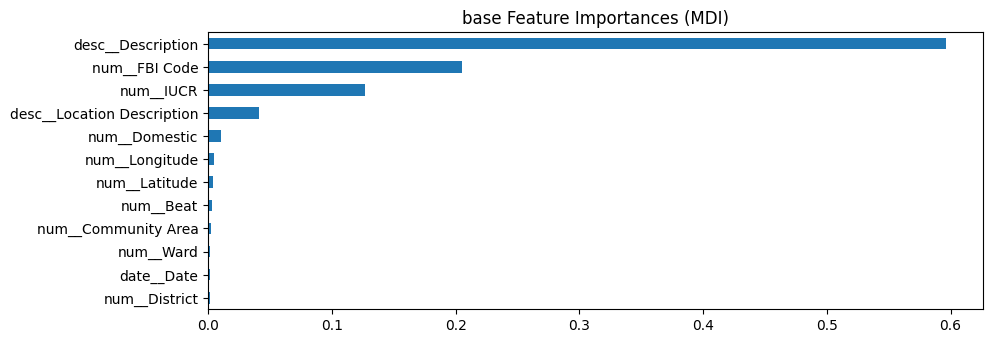

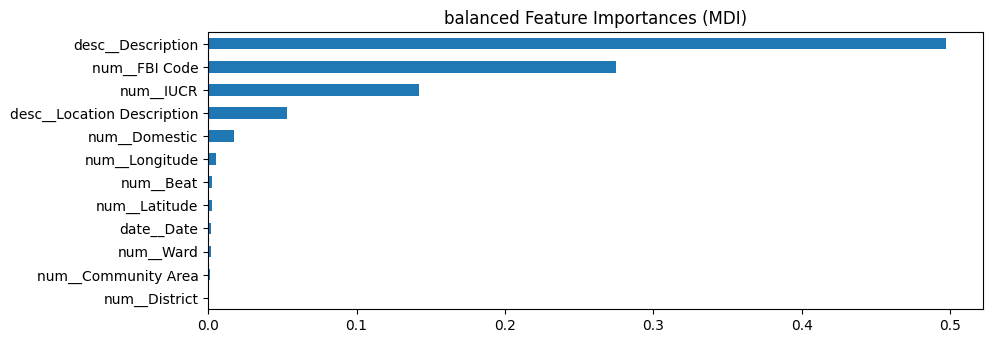

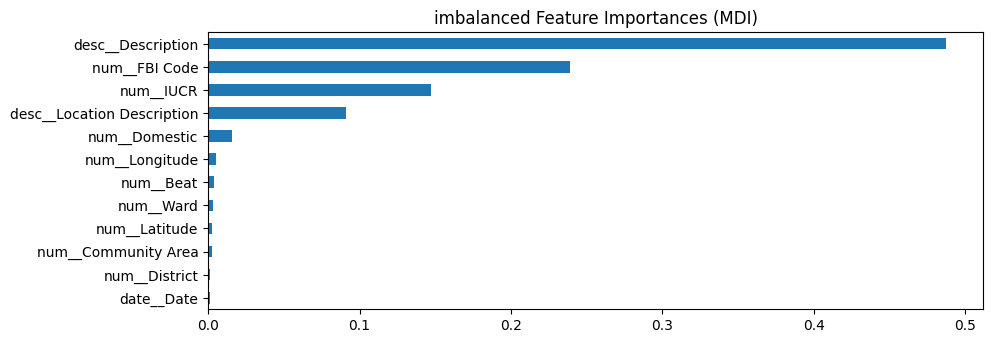

In [4]:
for key, best_model in best_models.items():
    model=best_model.named_steps['clf']
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    # Get the transformed feature names
    mdi_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)

    # Set figure size to increase spacing
    plt.figure(figsize=(10, len(mdi_importances) * 0.3))  # Adjust the height based on the number of features

    # Plot the importances
    ax = mdi_importances.plot.barh()
    ax.set_title(f"{key} Feature Importances (MDI)")

    # Optionally, you can increase the font size for y-axis labels
    ax.tick_params(axis='y', labelsize=10)  # Adjust labelsize for readability
    plt.savefig(f'Graphs/{key}_feature_importance.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
    plt.show()

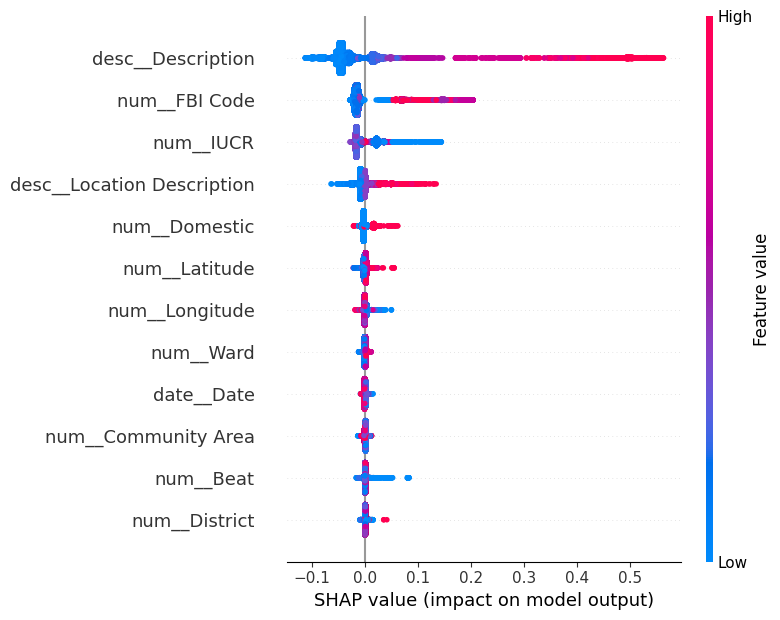

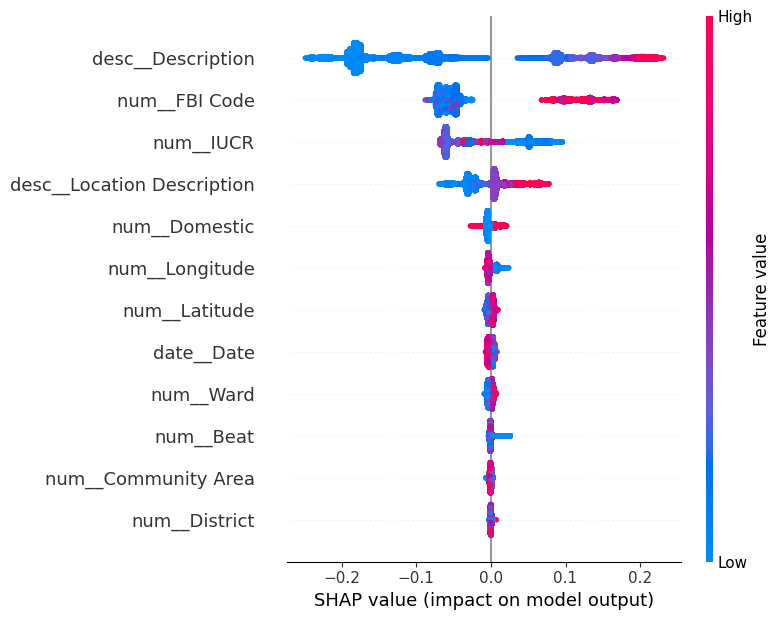

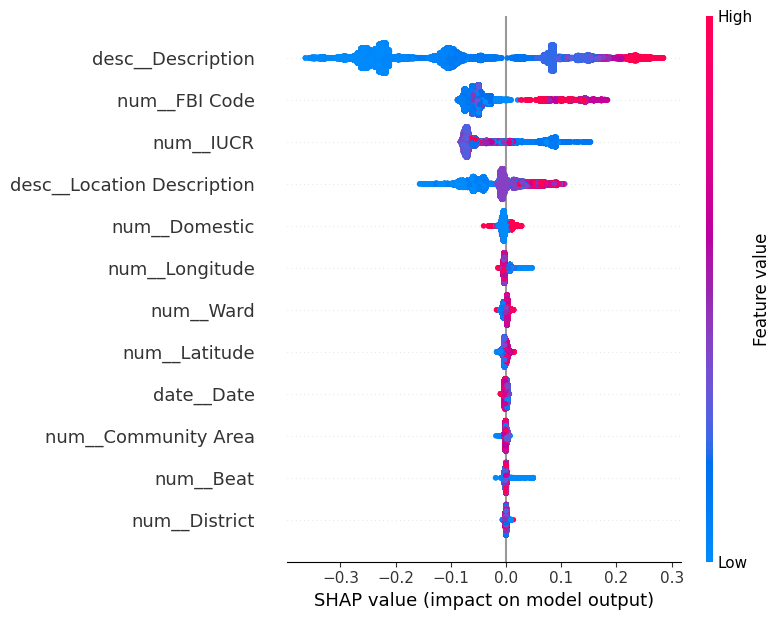

In [5]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed = best_model.named_steps['ct'].transform(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed)
    shap.summary_plot(shap_values[:,:,1,], x_val_transformed, feature_names=feature_names, show=False)
    plt.savefig(f'Graphs/{key}_shap_impact.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
    plt.show()

In [6]:
# shap.dependence_plot('Alm', shap_values[:,:,1], x_val_transformed_name)
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_shap_dependence'
    os.makedirs(output_dir, exist_ok=True)
    
    for feature in feature_names:
        plt.figure()  # Explicitly create a new figure
        shap.dependence_plot(feature, shap_values[:,:,1], x_val_transformed_name, show=False)
        plt.savefig(f'{output_dir}/{feature}.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
        # plt.show()
        plt.close()  # Close the plot to free up memory

    

/Users/coletonwatt/Developer/MATH 4750/Math4750 Final Project Data Modeling/.venv/lib/python3.12/site-packages/shap/plots/_scatter.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=figsize)
/var/folders/1q/yvy8f7x573v6gq0wpf2grhx40000gn/T/ipykernel_67465/2417158977.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # Explicitly create a new figure


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
shap.initjs()

In [8]:
rows_selection = [1,2,3,4,5,6,7,8,9,10]

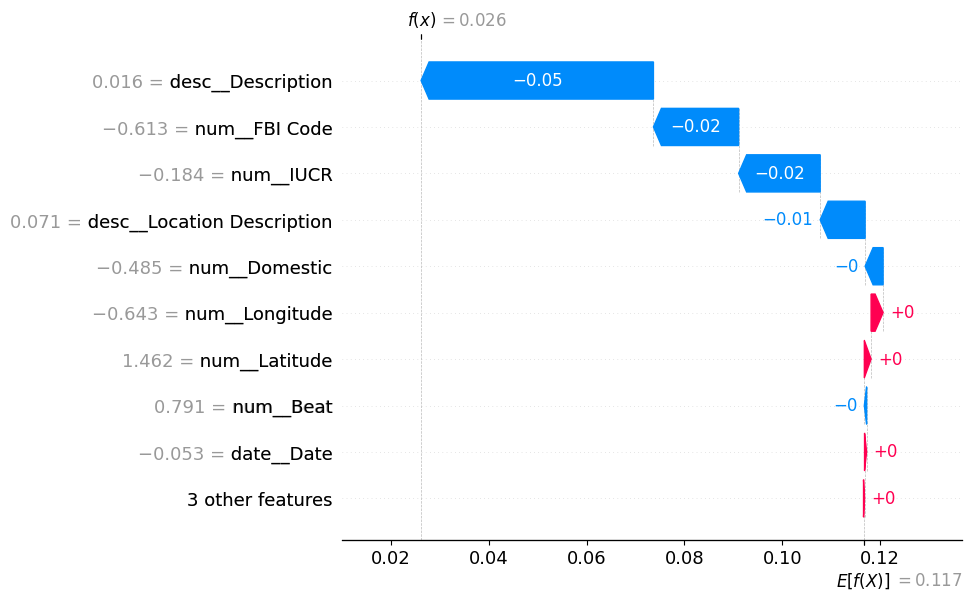

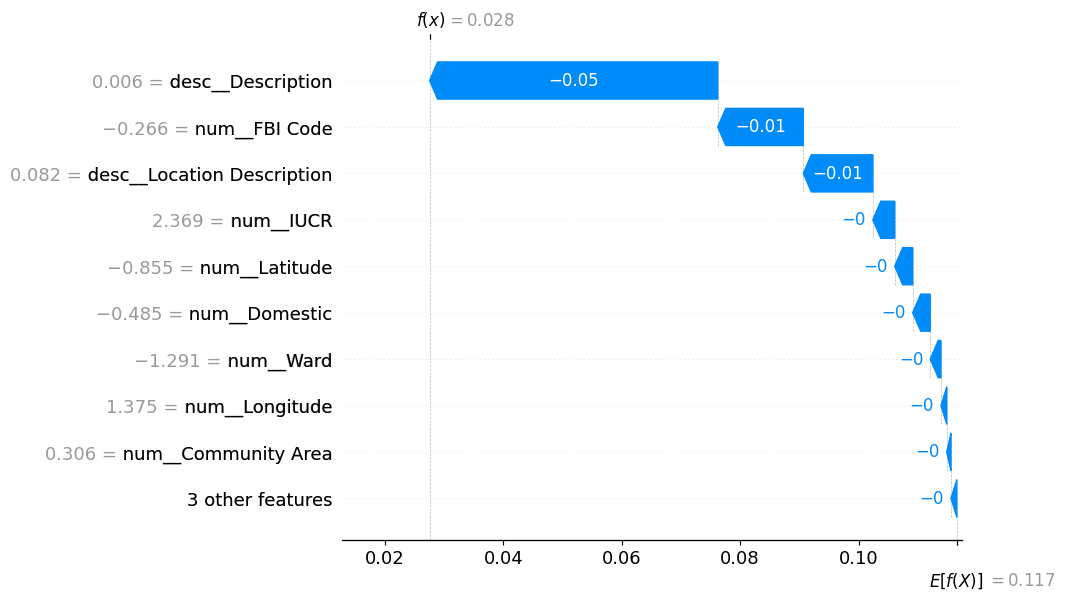

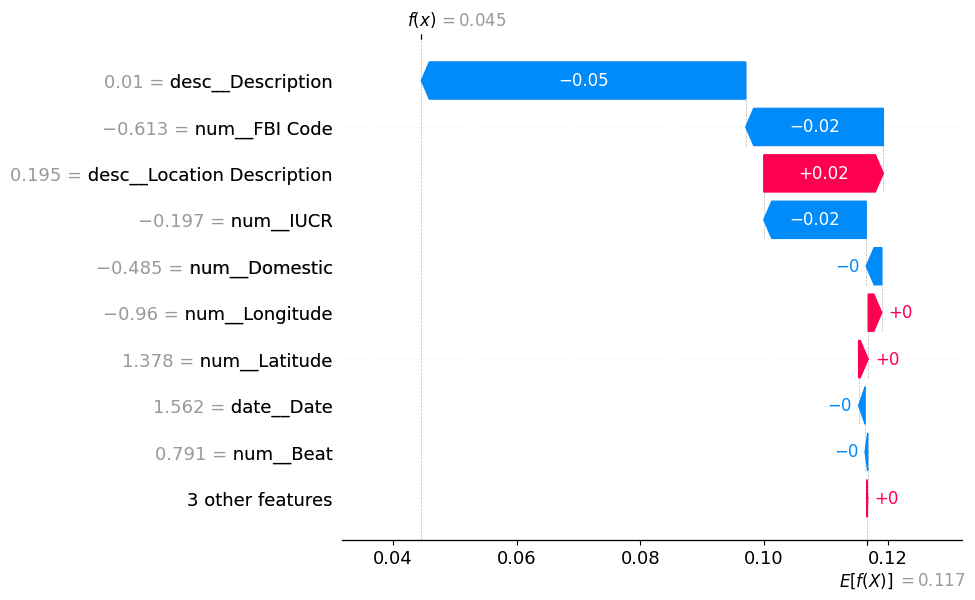

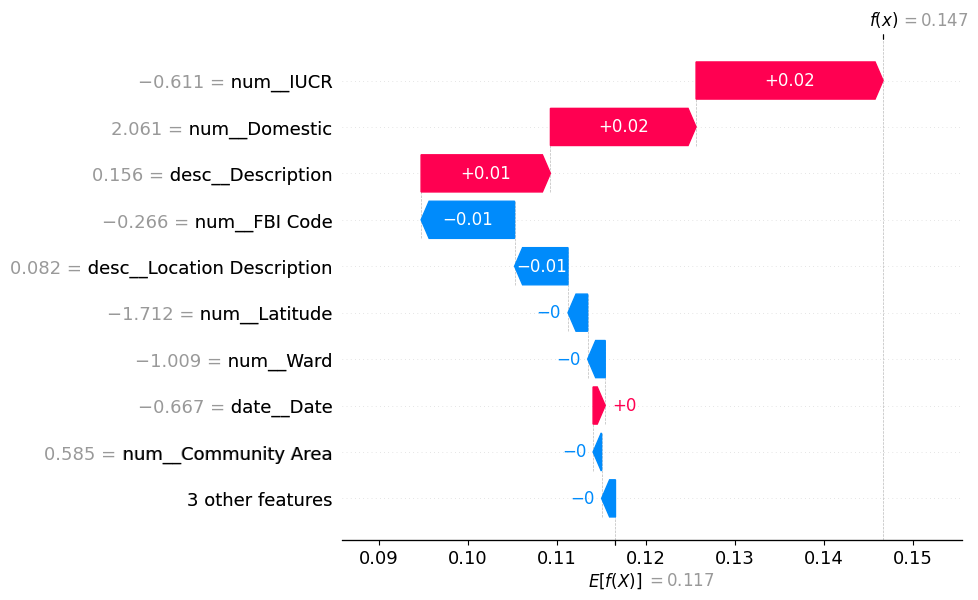

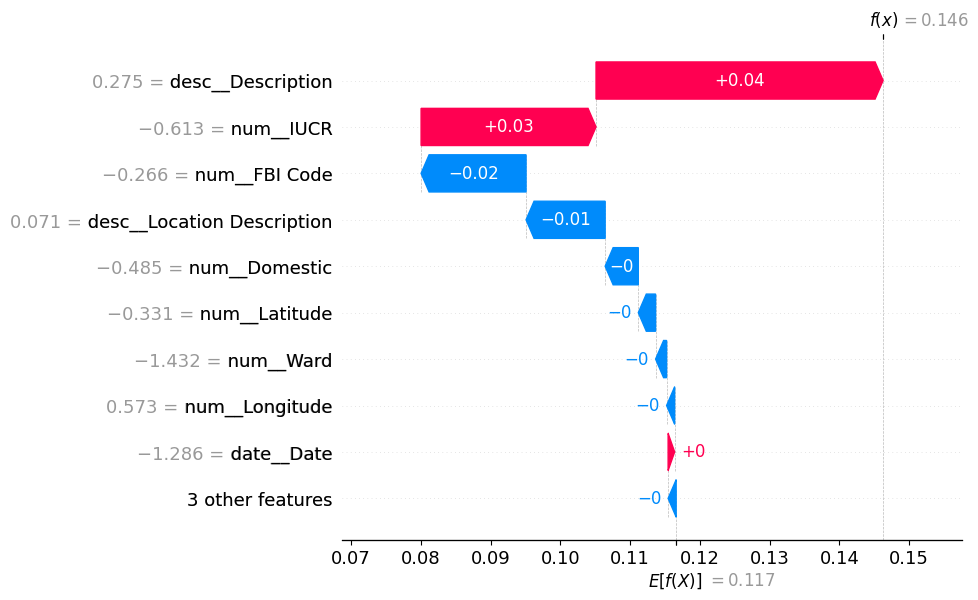

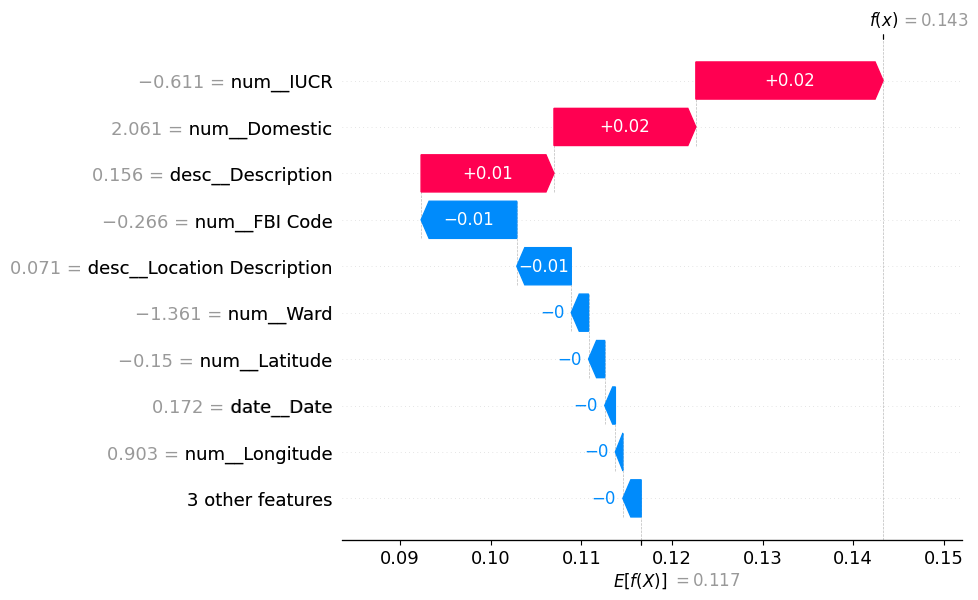

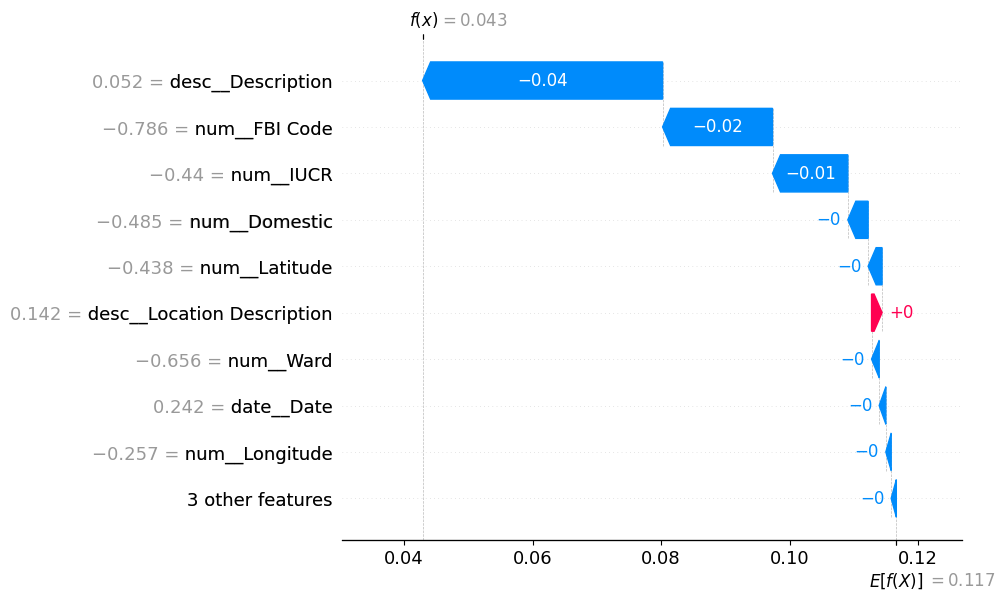

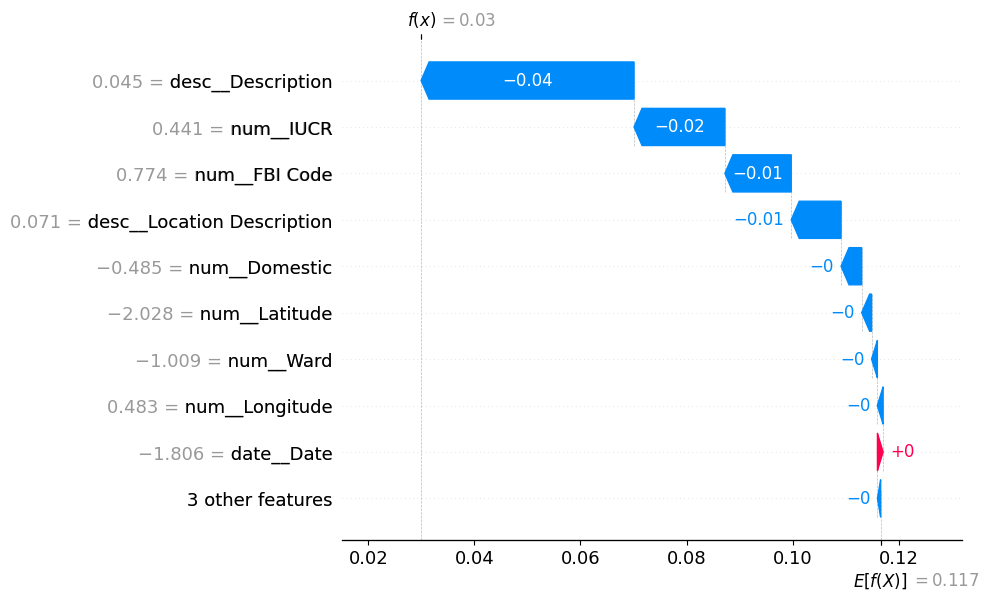

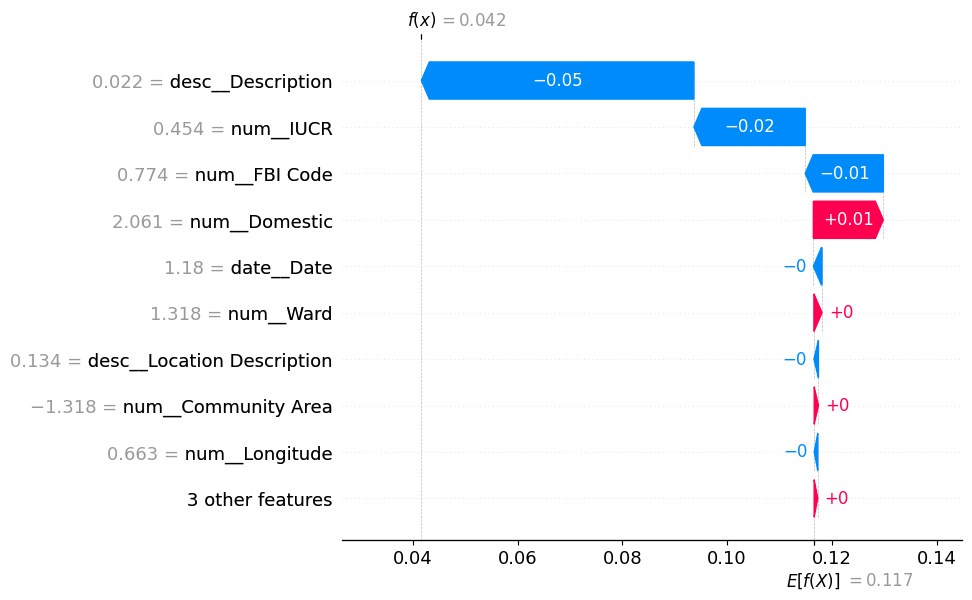

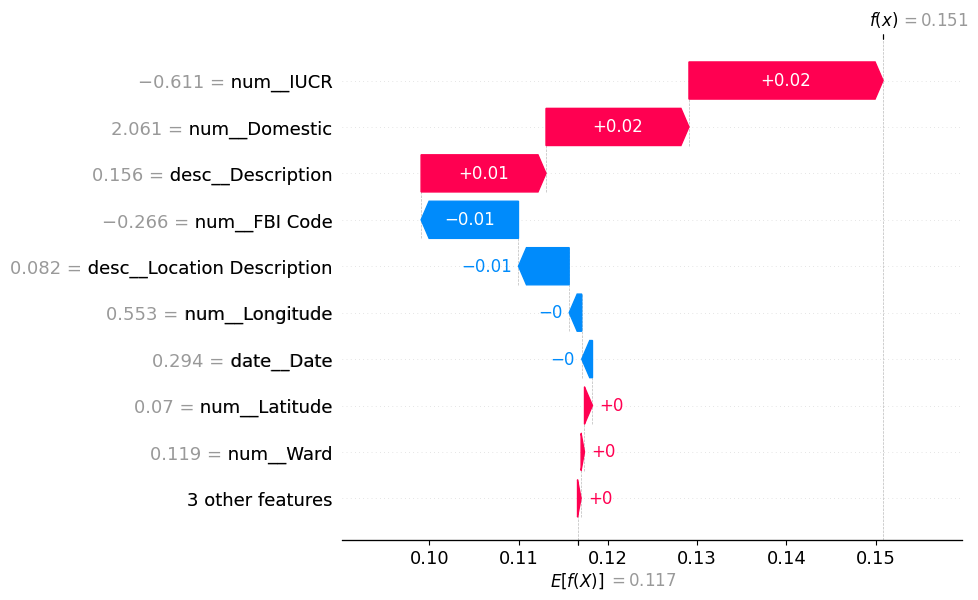

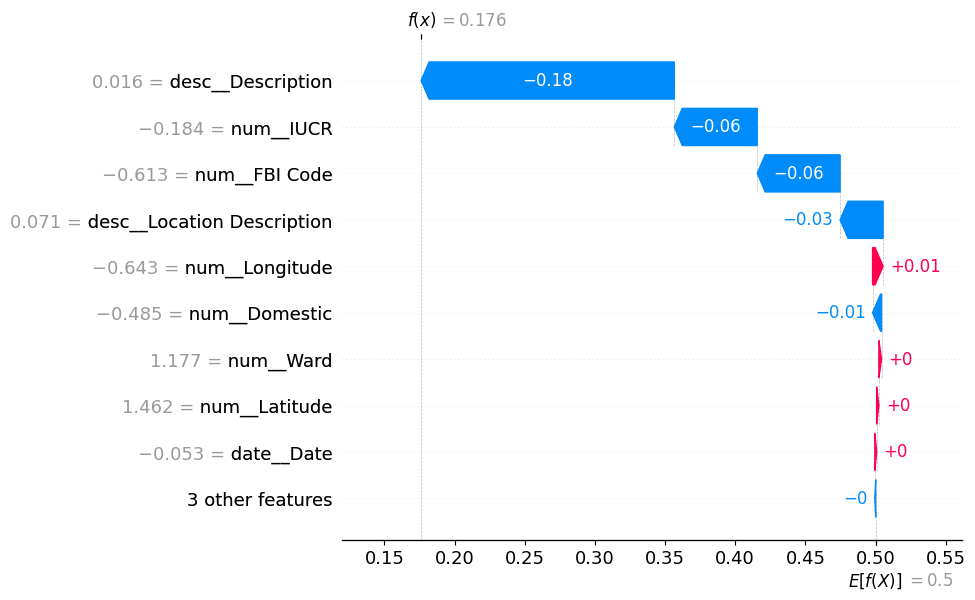

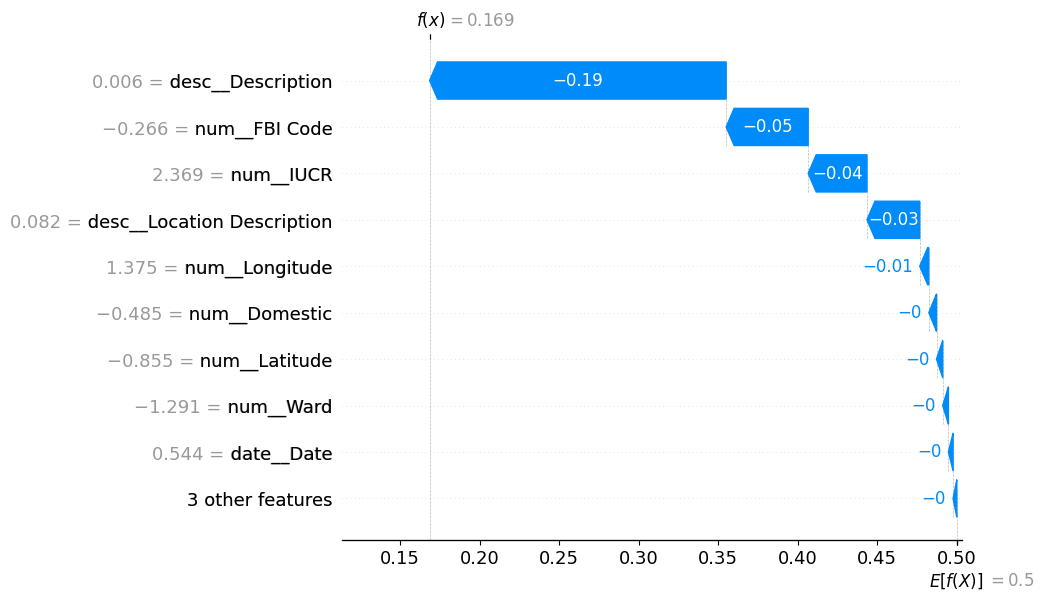

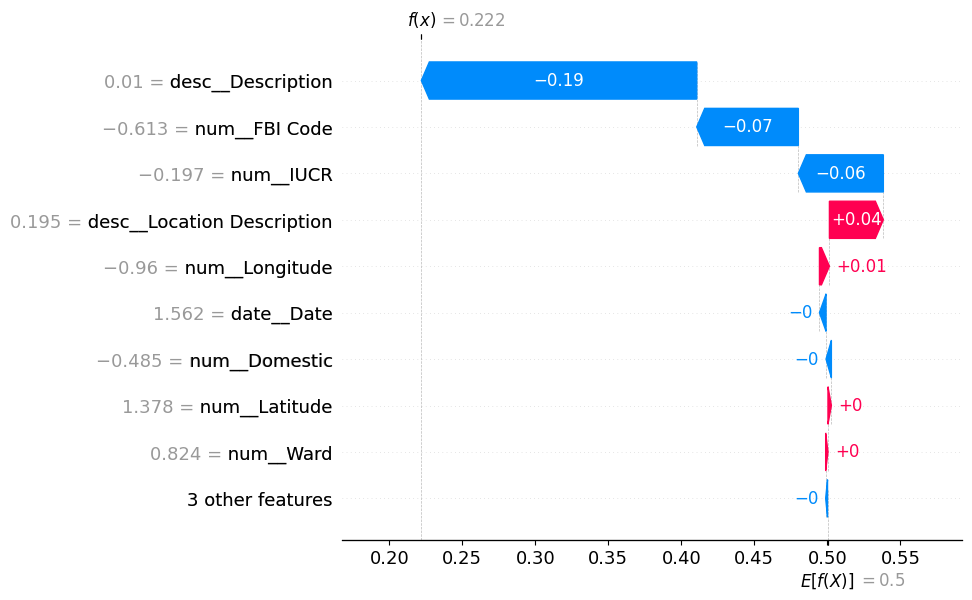

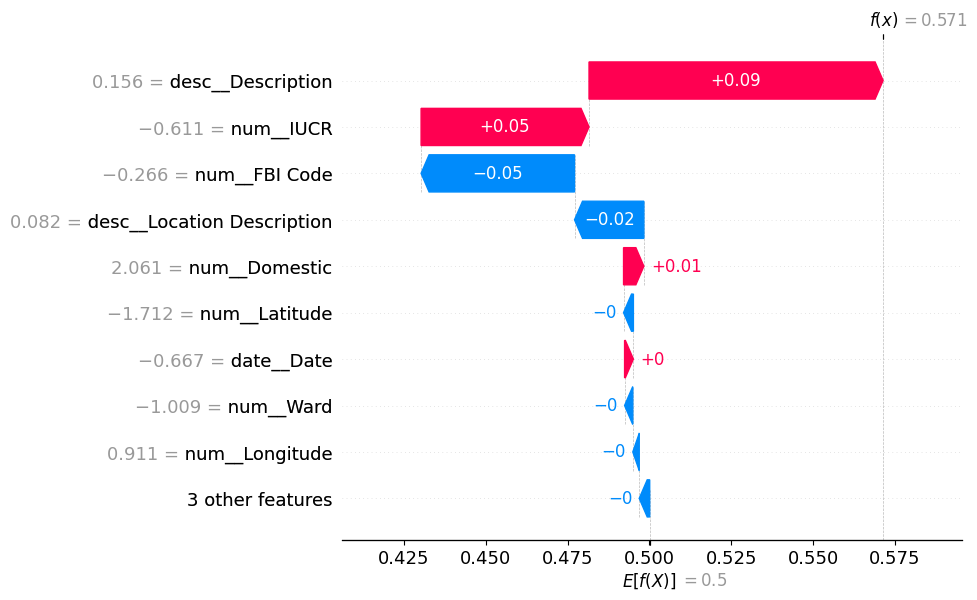

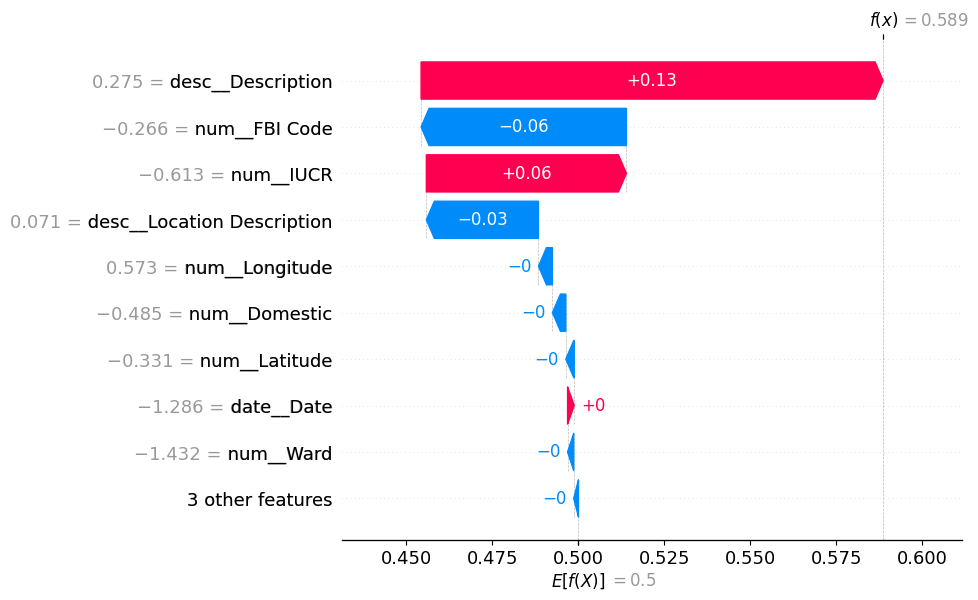

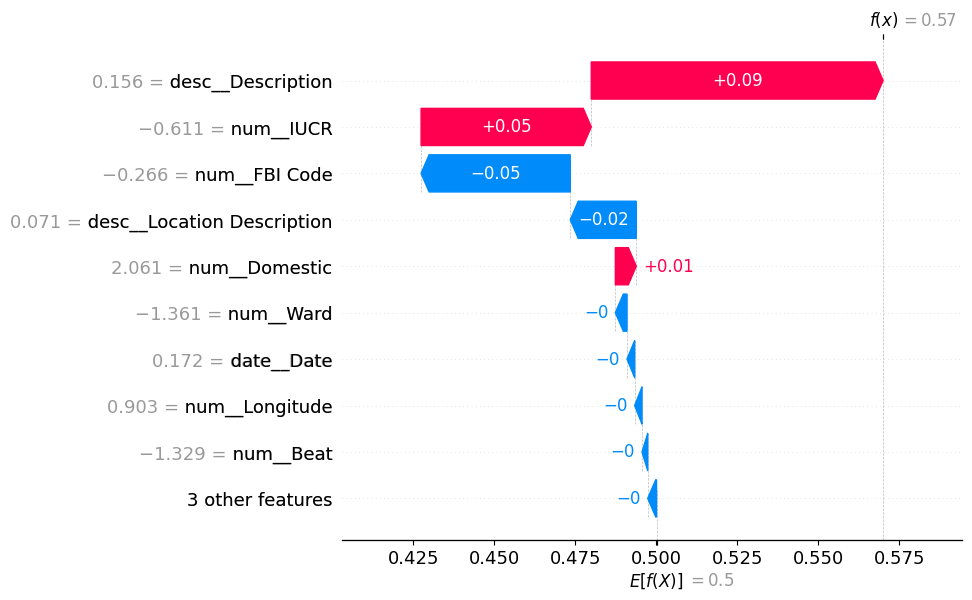

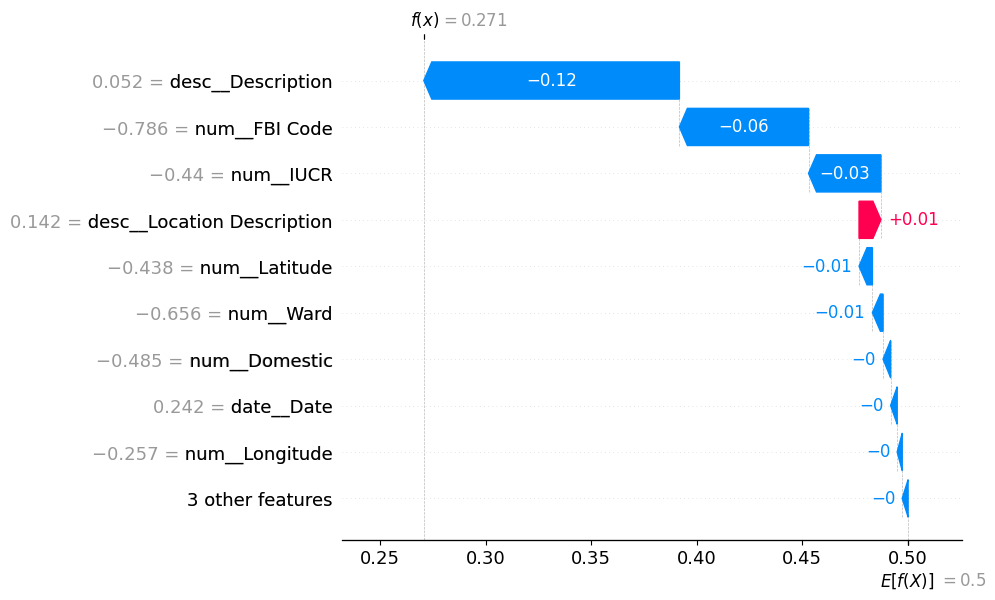

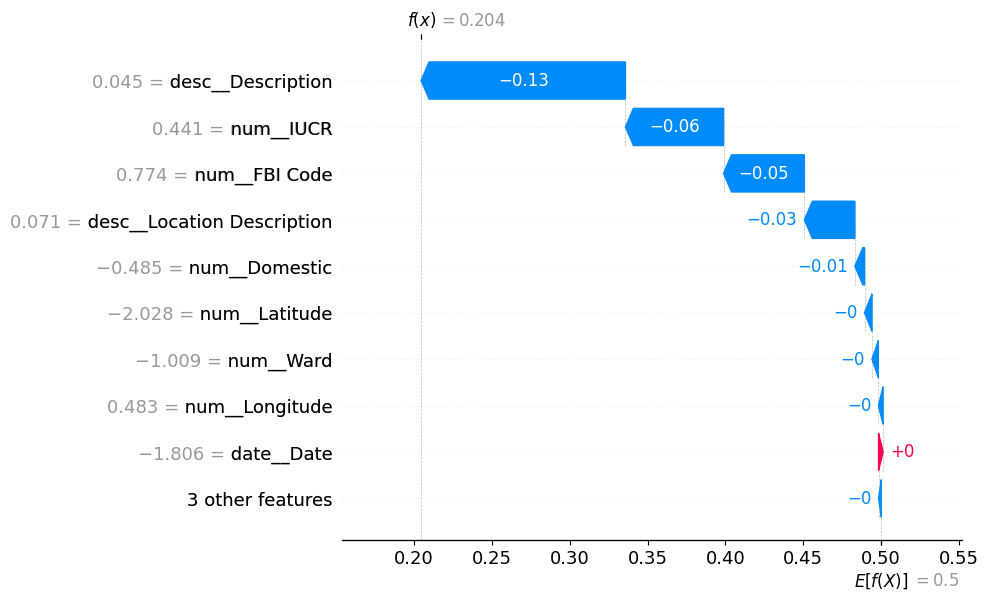

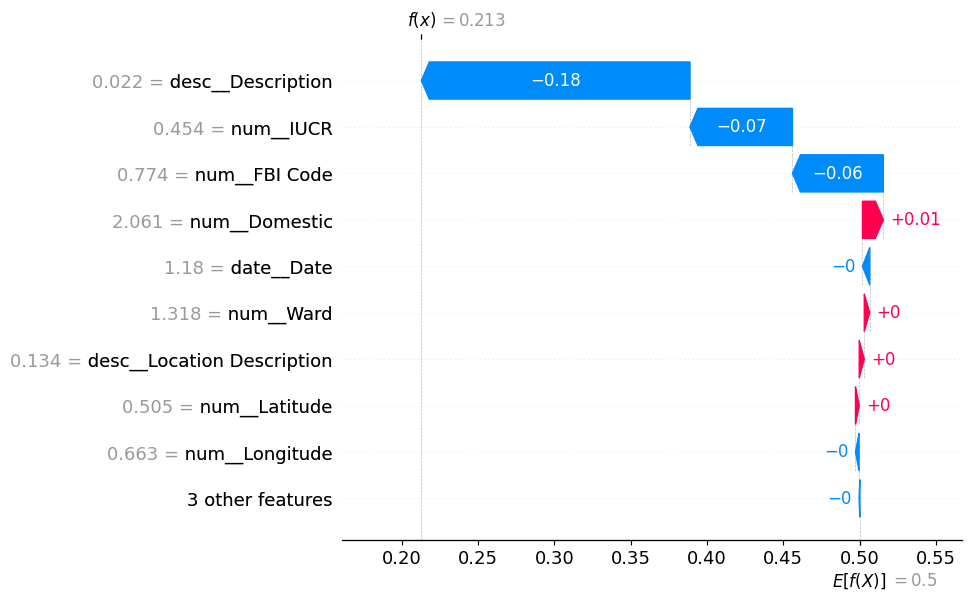

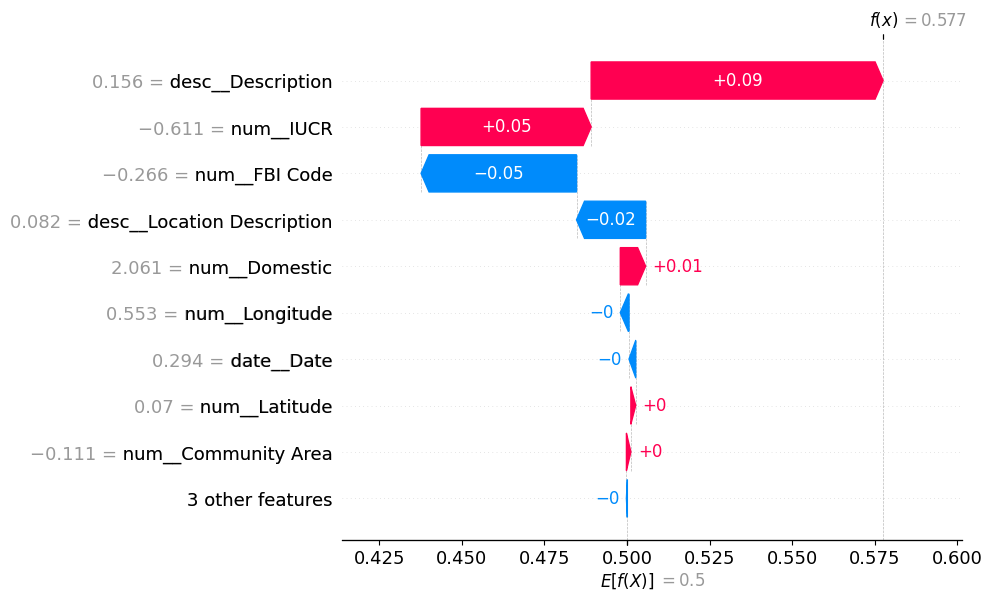

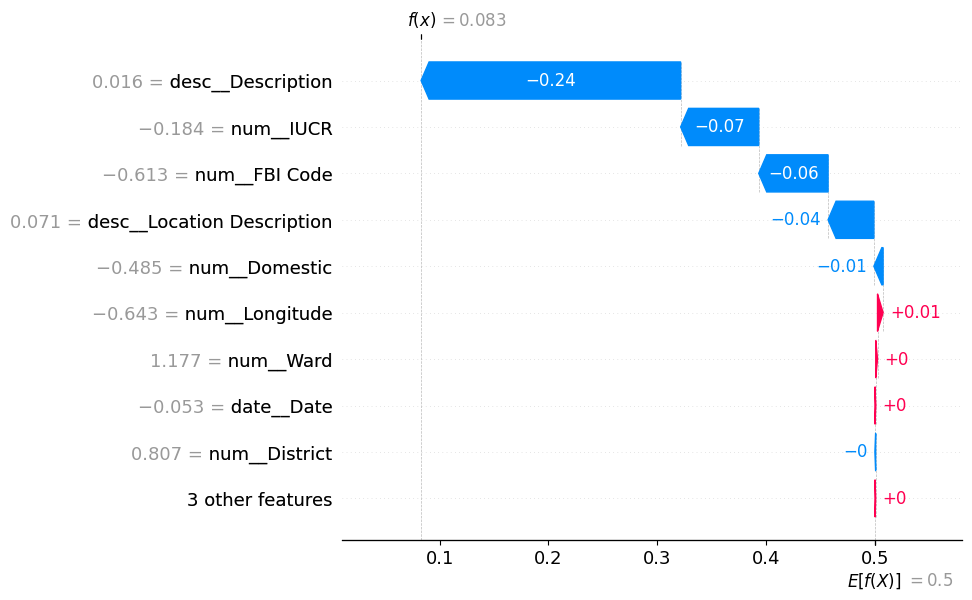

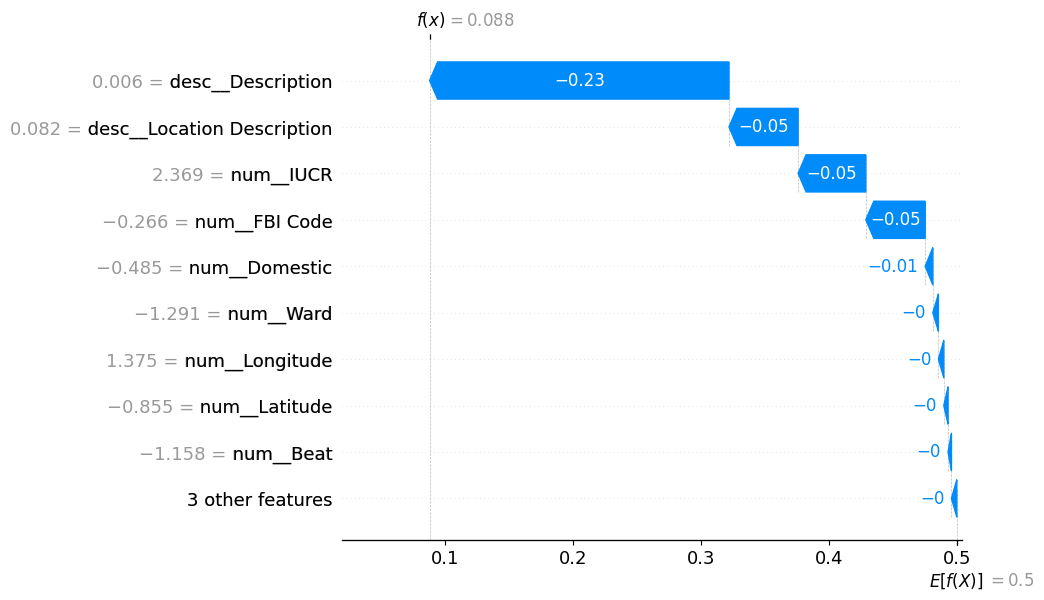

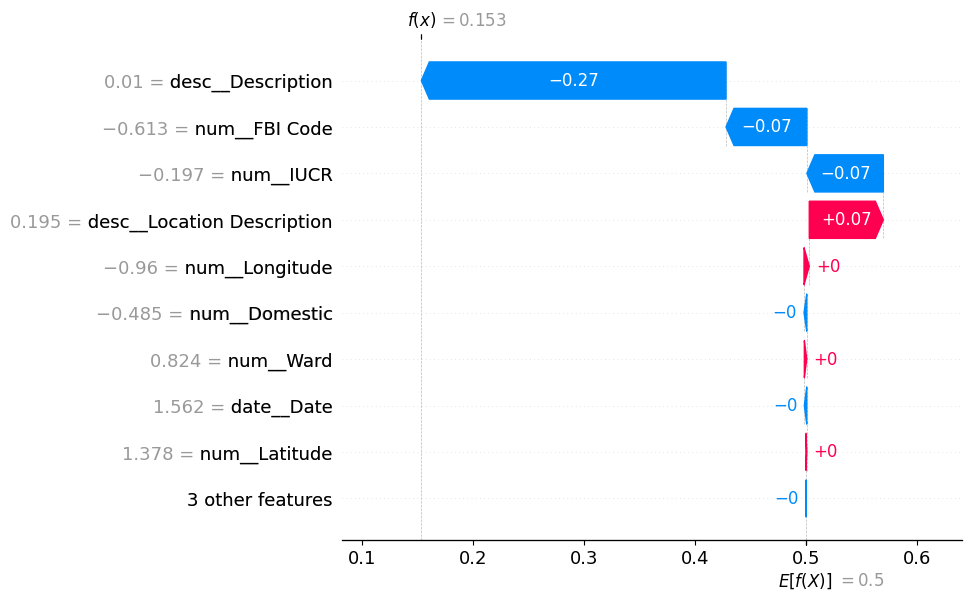

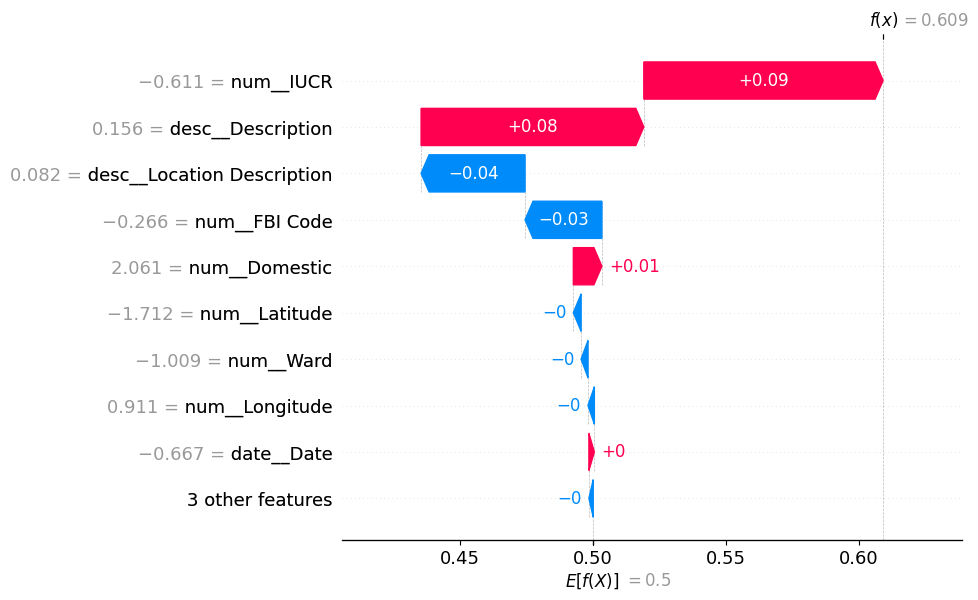

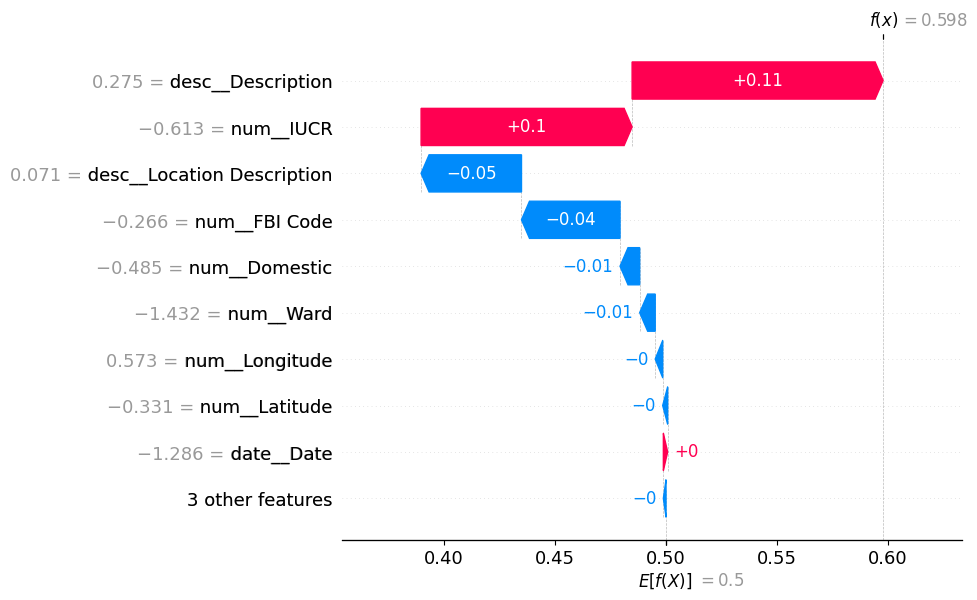

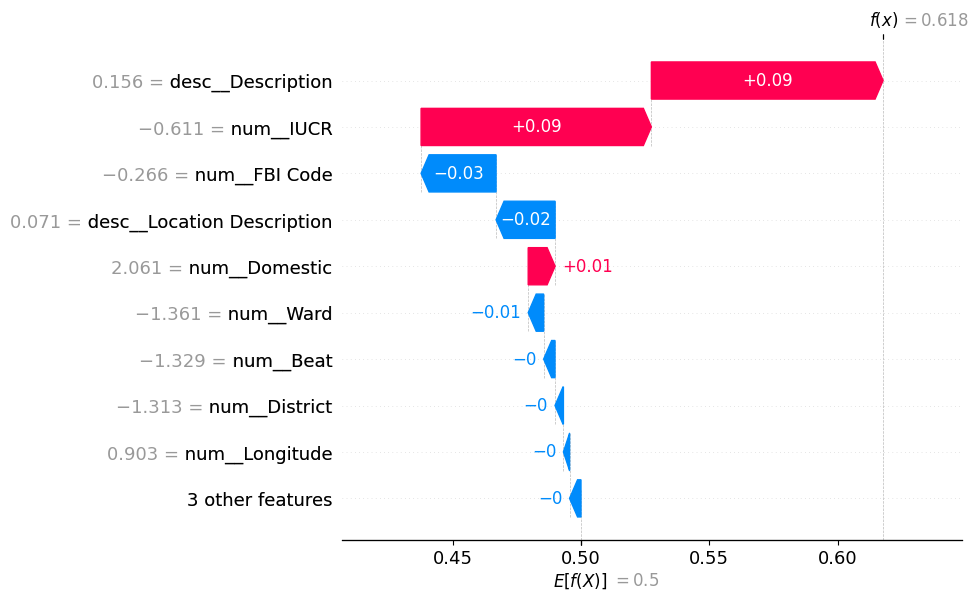

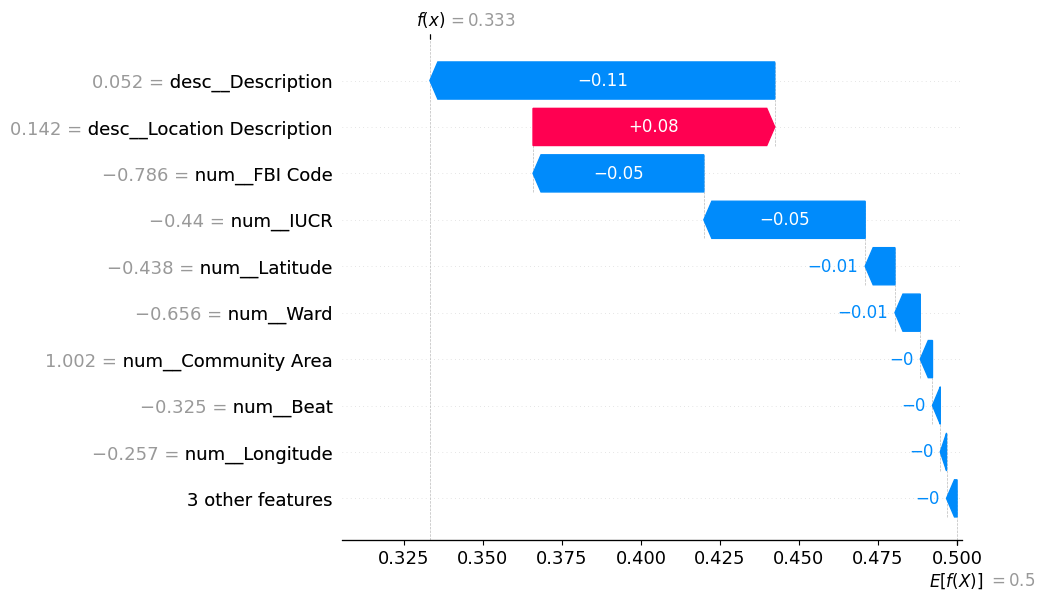

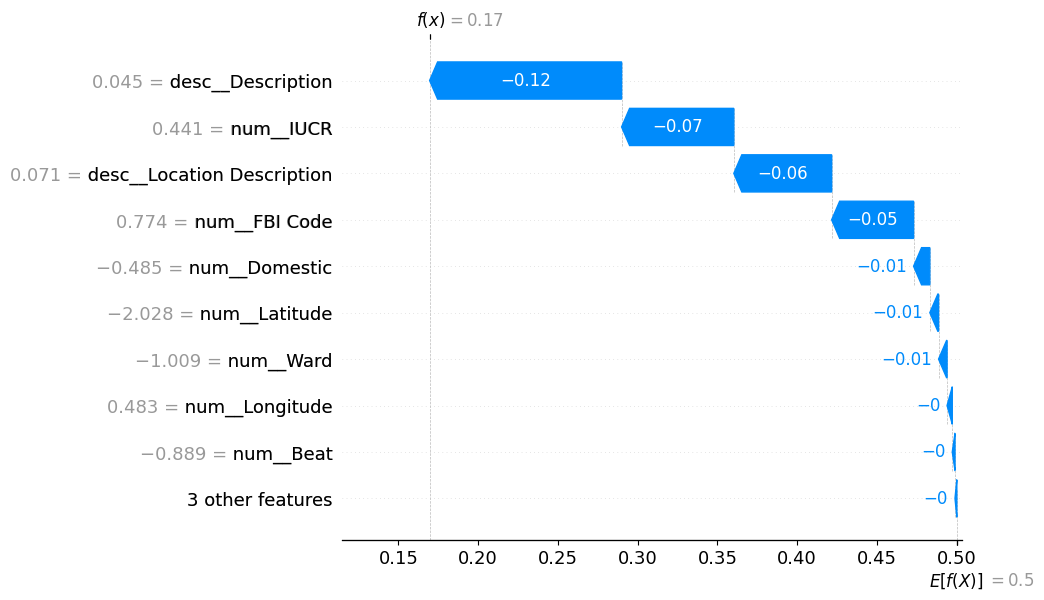

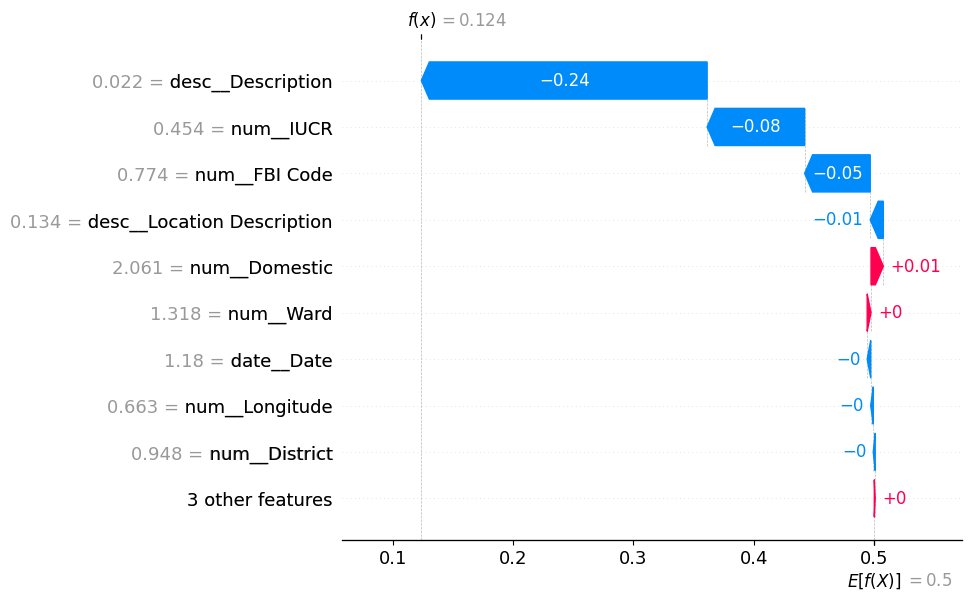

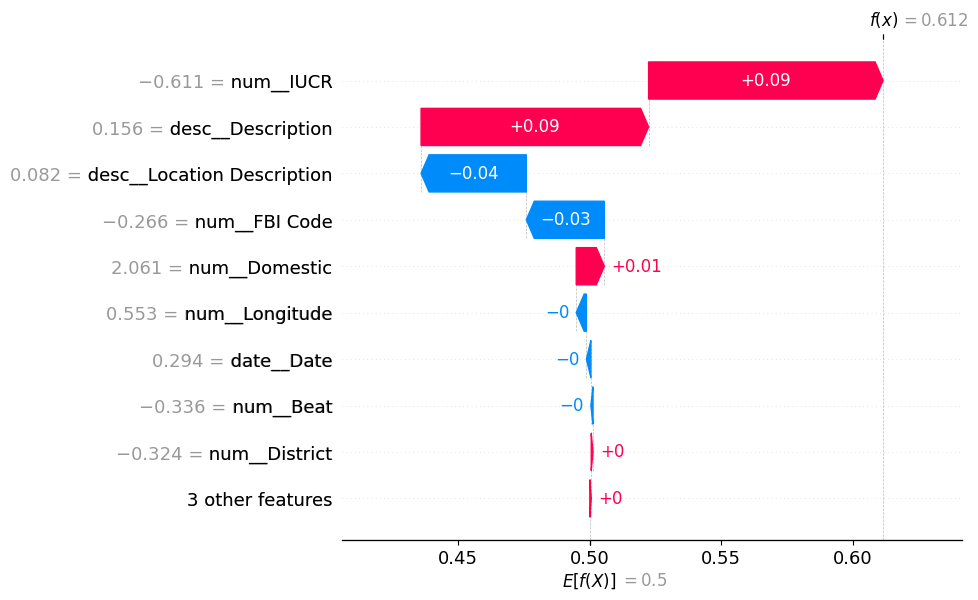

In [9]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_waterfall_plot'
    os.makedirs(output_dir, exist_ok=True)
    
    for row in rows_selection:
        fig = plt.figure(figsize=(6, 3.3))
        explanation5 = shap.Explanation(
            values=shap_values[row, :, 1],  # Select SHAP values for the specific class
            base_values=explainer.expected_value[1],  # Use expected value for the same class
            #feature_names=X_test.columns,
            data=x_val_transformed_name.iloc[row, :]
        )
        shap.plots.waterfall(explanation5)
        fig.tight_layout()
        fig.savefig(f'{output_dir}/Details{row}.jpg', format='jpeg', dpi=300, bbox_inches='tight')

In [10]:
# for key, best_model in best_models.items():
#     if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
#         feature_names = best_model.named_steps['ct'].get_feature_names_out()
#     else:
#         feature_names = best_model.named_steps['ct'].get_feature_names()
#     model=best_model.named_steps['clf']
#     x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(x_val_transformed_name)

#     # Create directory for saving plots
#     output_dir = f'Graphs/{key}_force_plots'
#     os.makedirs(output_dir, exist_ok=True)
#     plt.figure()

#     shap.plots.force(
#         base_value=explainer.expected_value[1],
#         shap_values=shap_values[1, :, 1],
#         features=x_val_transformed_name.iloc[1, :]
#     )
#     plt.savefig(f'{output_dir}/Details_ahhh.jpg', format='jpeg', dpi=300, bbox_inches='tight')
#     plt.close()  # Ensure plots are closed

    
#     # for row in rows_selection:
#     #     # plt.figure()  # Explicitly create a new figure
#     #     # shap.force_plot(explainer.expected_value[1], shap_values[row,:,1], x_val_transformed_name.iloc[row,:])
#     #     plt.figure()
#     #     shap.plots.force(
#     #         base_value=explainer.expected_value[1],
#     #         shap_values=shap_values[row, :, 1],
#     #         features=x_val_transformed_name.iloc[row, :]
#     #     )
#     #     plt.savefig(f'{output_dir}/Details_{row}.jpg', format='jpeg', dpi=300, bbox_inches='tight')
#     #     plt.close()  # Ensure plots are closed
#     #     # plt.savefig(f'{output_dir}/Details_{row}.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
#     #     # plt.close()  # Close the plot to free up memory